י המטלה שהוגדרה היא סיווג תמונות של פריטי אופנה (10 קטגוריות: חולצה, מכנס, סוודר, שמלה, מעיל, סנדל, חולצת טי, נעלי ספורט, תיק, מגפיים). המידע כולל תמונות בשחור-לבן של 28 על 28 פיקסלים, כאשר המטרה היא לפתח מודל חיזוי יעיל. י

י פרמטרים מרכזיים להשוואה בין המודלים: י
י • $דיוק$ ($Accuracy$): אחוז התשובות הנכונות של המודל. י  
י • $Recall$ ו-$Precision$: להערכת האיכות בכל קטגוריה. י  
י • זמן האימון והחיזוי: משפיע על בחירת המודל, במיוחד במציאות תעשייתית. י  


Data shape: (60000, 785)
Label distribution:
 label
2    6000
9    6000
6    6000
0    6000
3    6000
4    6000
5    6000
8    6000
7    6000
1    6000
Name: count, dtype: int64


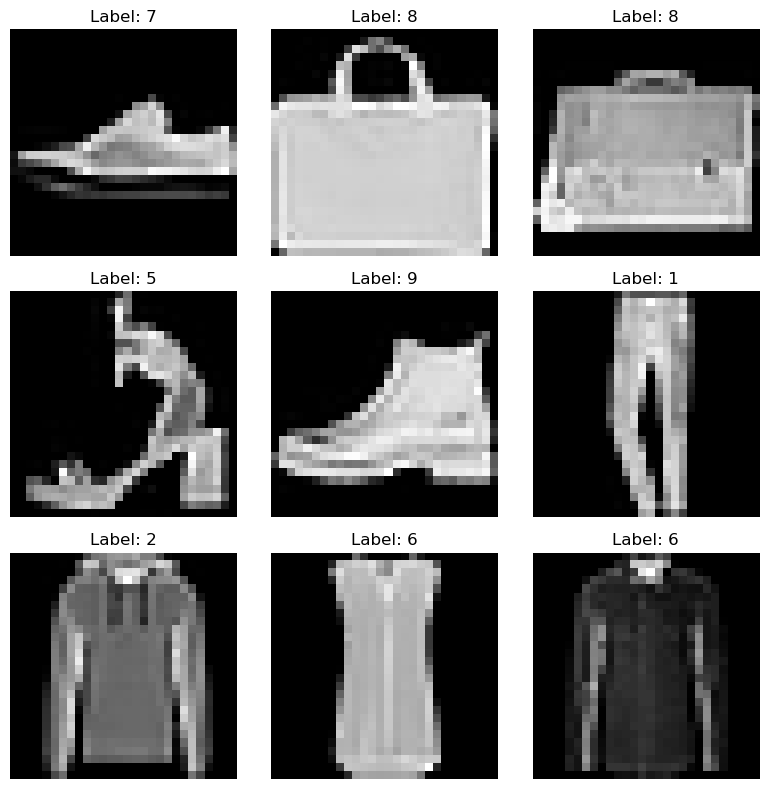

Training set shape: (48000, 784)
Validation set shape: (12000, 784)


In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

# For reproducibility
RANDOM_STATE = 42

# ------------------------------
# 1. Data Loading and Exploration
# ------------------------------

# Load the dataset (ensure 'train.csv' is in your working directory)
df = pd.read_csv("train.csv")
print("Data shape:", df.shape)
print("Label distribution:\n", df['label'].value_counts())

# Function to visualize sample images
def plot_sample_images(data, num_samples=9):
    fig, axes = plt.subplots(3, 3, figsize=(8,8))
    axes = axes.flatten()
    for ax, (_, row) in zip(axes, data.iterrows()):
        # Reshape pixel values into a 28x28 image
        image = row[1:].values.reshape(28, 28).astype(np.uint8)
        label = row['label']
        ax.imshow(image, cmap='gray')
        ax.set_title(f"Label: {label}")
        ax.axis("off")
    plt.tight_layout()
    plt.show()

# Display 9 random images
plot_sample_images(df.sample(9, random_state=RANDOM_STATE))

# ------------------------------
# 2. Data Preprocessing
# ------------------------------

# Separate features and target variable
X = df.drop('label', axis=1)
y = df['label']

# Normalize pixel values to range [0,1]
X = X / 255.0

# Split data into training and validation sets (80/20 split, stratified by label)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)


# ---- Model 1: PCA + Logistic Regression ----


י • תיאור: שימוש ב-$PCA$ (אנליזת רכיבים ראשיים) להקטנת המימדיות, ולאחר מכן ביצוע רגרסיה לוגיסטית על הנתונים המצומצמים. י  
י • יתרונות: י  
י • הפחתת המימדיות מקצרת את זמן החישוב. י  
י • קל לפרש ולהבין. י  
י • חסרונות: י  
י • אובדן מידע בעת צמצום המימדיות. י  
י • דיוק נמוך יחסית למודלים מורכבים יותר. י  
י • דיוק: $84.87%$. י  


Explained variance ratio (first 10 components): [0.28942933 0.17741295 0.06041128 0.04987945 0.03853544 0.03474293
 0.02339002 0.01915571 0.01343886 0.0130878 ]
16.24952793121338 sec
Best logistic regression parameters: {'C': 1}
Logistic Regression (with PCA) Accuracy on Validation set: 0.8487

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.80      0.82      0.81      1200
           1       0.96      0.97      0.97      1200
           2       0.76      0.74      0.75      1200
           3       0.84      0.86      0.85      1200
           4       0.73      0.78      0.75      1200
           5       0.94      0.94      0.94      1200
           6       0.63      0.56      0.59      1200
           7       0.92      0.93      0.92      1200
           8       0.95      0.94      0.95      1200
           9       0.95      0.94      0.95      1200

    accuracy                           0.85     12000
   macr

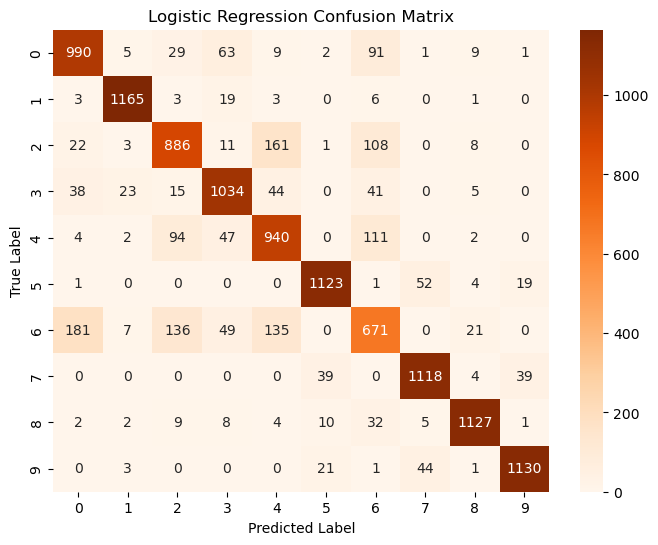

In [2]:
import time
tic = time.time()

# Reduce dimensionality using PCA (e.g., 100 components)
n_components = 100
pca = PCA(n_components=n_components, random_state=RANDOM_STATE)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
print("Explained variance ratio (first 10 components):", pca.explained_variance_ratio_[:10])

# Initialize logistic regression with increased max_iter for convergence
lr = LogisticRegression(max_iter=1000, solver='lbfgs', random_state=RANDOM_STATE)

# Tune regularization parameter 'C' using GridSearchCV with 3-fold CV for speed
param_grid_lr = {'C': [0.1, 1, 10]}
grid_lr = GridSearchCV(lr, param_grid_lr, cv=3, scoring='accuracy', n_jobs=-1)
grid_lr.fit(X_train_pca, y_train)

toc = time.time()
time1 = toc - tic
print(toc - tic , "sec")
print("Best logistic regression parameters:", grid_lr.best_params_)
best_lr = grid_lr.best_estimator_

# Evaluate logistic regression model
y_pred_lr = best_lr.predict(X_val_pca)
accuracy_lr = accuracy_score(y_val, y_pred_lr)
print("Logistic Regression (with PCA) Accuracy on Validation set: {:.4f}".format(accuracy_lr))
print("\nClassification Report for Logistic Regression:")
print(classification_report(y_val, y_pred_lr))

# Plot confusion matrix for Logistic Regression
cm_lr = confusion_matrix(y_val, y_pred_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Logistic Regression Confusion Matrix")
plt.show()


# ---- Model 2: Random Forest Classifier using RandomizedSearchCV ----


י • תיאור: סיווג מבוסס עצים רנדומליים. י  
י • יתרונות: י  
י • דיוק גבוה יותר מרוב המודלים הפשוטים. י  
י • פחות רגיש לרעש. י  
י • חסרונות: י  
י • זמני אימון ארוכים יותר. י  
י • מודל פחות אינטואיטיבי לפרשנות. י  
י • דיוק: $87.93%$. י  


71.909010887146 sec
Best Random Forest parameters: {'n_estimators': 100, 'max_depth': None}
Random Forest Accuracy on Validation set: 0.8793

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84      1200
           1       0.99      0.97      0.98      1200
           2       0.78      0.81      0.80      1200
           3       0.89      0.92      0.90      1200
           4       0.76      0.83      0.79      1200
           5       0.98      0.96      0.97      1200
           6       0.74      0.58      0.65      1200
           7       0.93      0.94      0.94      1200
           8       0.97      0.97      0.97      1200
           9       0.95      0.95      0.95      1200

    accuracy                           0.88     12000
   macro avg       0.88      0.88      0.88     12000
weighted avg       0.88      0.88      0.88     12000



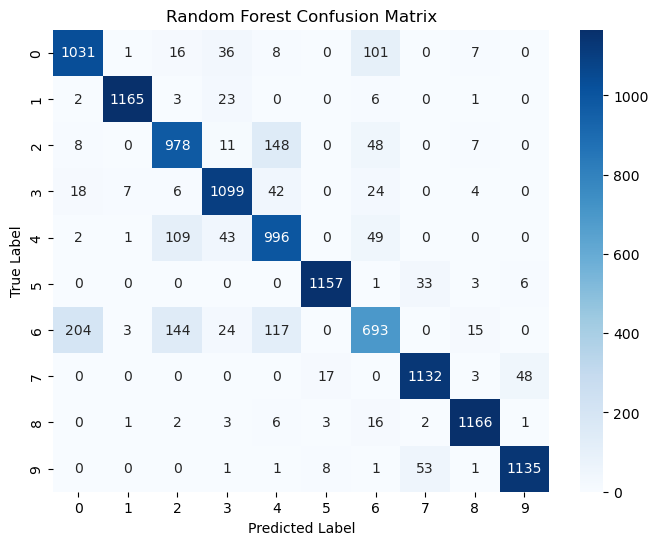

In [3]:
import time
tic = time.time()


# Initialize Random Forest classifier
rf = RandomForestClassifier(random_state=RANDOM_STATE)

# Define a smaller hyperparameter space for a faster search
param_dist_rf = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10]
}

# Use RandomizedSearchCV with 3-fold CV and 4 iterations to reduce runtime
random_search_rf = RandomizedSearchCV(
    rf,
    param_distributions=param_dist_rf,
    n_iter=4,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    random_state=RANDOM_STATE
)
random_search_rf.fit(X_train, y_train)

toc = time.time()
time2 = toc - tic
print(toc - tic , "sec")

print("Best Random Forest parameters:", random_search_rf.best_params_)
best_rf = random_search_rf.best_estimator_

# Evaluate Random Forest model
y_pred_rf = best_rf.predict(X_val)
accuracy_rf = accuracy_score(y_val, y_pred_rf)
print("Random Forest Accuracy on Validation set: {:.4f}".format(accuracy_rf))
print("\nClassification Report for Random Forest:")
print(classification_report(y_val, y_pred_rf))

# Plot confusion matrix for Random Forest
cm_rf = confusion_matrix(y_val, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Random Forest Confusion Matrix")
plt.show()


# ---- Model 3: Naive Bayes Classifier (Baseline) ----


י • תיאור: מודל סטטיסטי פשוט המבוסס על הסתברות ונאיביות (אי תלות בין משתנים). י  
י • יתרונות: י  
י • מהיר במיוחד. י  
י • מתאים כבסיס להשוואה ($Baseline$). י  
י • חסרונות: י  
י • דיוק נמוך יחסית. י  
י • מניח הנחות לא ריאליות (אי תלות בין פיקסלים). י  
י • דיוק: $58.55%$. י  

0.3390059471130371 sec
Naive Bayes Accuracy on Validation set: 0.5855

Classification Report for Naive Bayes:
              precision    recall  f1-score   support

           0       0.81      0.60      0.69      1200
           1       0.64      0.95      0.77      1200
           2       0.59      0.30      0.40      1200
           3       0.45      0.56      0.50      1200
           4       0.37      0.76      0.50      1200
           5       0.90      0.28      0.42      1200
           6       0.25      0.03      0.05      1200
           7       0.50      0.98      0.66      1200
           8       0.87      0.72      0.79      1200
           9       0.94      0.66      0.78      1200

    accuracy                           0.59     12000
   macro avg       0.63      0.59      0.56     12000
weighted avg       0.63      0.59      0.56     12000



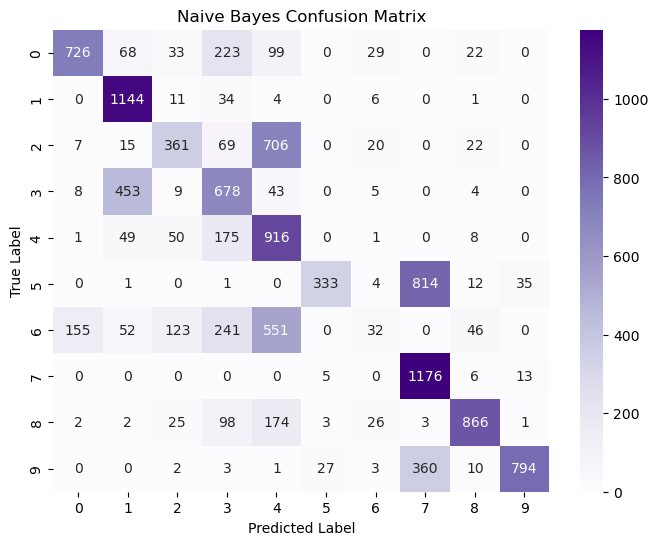

In [4]:
import time
tic = time.time()



from sklearn.naive_bayes import GaussianNB

# Initialize and train Gaussian Naive Bayes classifier
nb = GaussianNB()
nb.fit(X_train, y_train)

# Evaluate Naive Bayes model
y_pred_nb = nb.predict(X_val)
accuracy_nb = accuracy_score(y_val, y_pred_nb)
toc = time.time()
time3 = toc - tic

print(toc - tic , "sec")
print("Naive Bayes Accuracy on Validation set: {:.4f}".format(accuracy_nb))
print("\nClassification Report for Naive Bayes:")
print(classification_report(y_val, y_pred_nb))

# Plot confusion matrix for Naive Bayes
cm_nb = confusion_matrix(y_val, y_pred_nb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Purples', 
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Naive Bayes Confusion Matrix")
plt.show()



# ---- Model 4: Bagging Classifier using Decision Trees and RandomizedSearchCV ----


י • תיאור: שילוב עצי החלטה רבים בשיטת $Bagging$. י  
י • יתרונות: י  
י • יציב יחסית מול רעש. י  
י • דיוק משופר בהשוואה לעץ החלטה יחיד. י  
י • חסרונות: י  
י • יכול להיות איטי יחסית לאימון. י
י • פחות שקיפות בפרשנות המודל. י
י • דיוק: $86.39%$. י

27.921977043151855 sec
Bagging Classifier Accuracy on Validation set: 0.8639

Classification Report for Bagging Classifier:
              precision    recall  f1-score   support

           0       0.80      0.84      0.82      1200
           1       0.98      0.97      0.97      1200
           2       0.75      0.81      0.78      1200
           3       0.87      0.89      0.88      1200
           4       0.75      0.80      0.77      1200
           5       0.95      0.95      0.95      1200
           6       0.71      0.56      0.63      1200
           7       0.92      0.93      0.92      1200
           8       0.95      0.96      0.96      1200
           9       0.95      0.94      0.94      1200

    accuracy                           0.86     12000
   macro avg       0.86      0.86      0.86     12000
weighted avg       0.86      0.86      0.86     12000



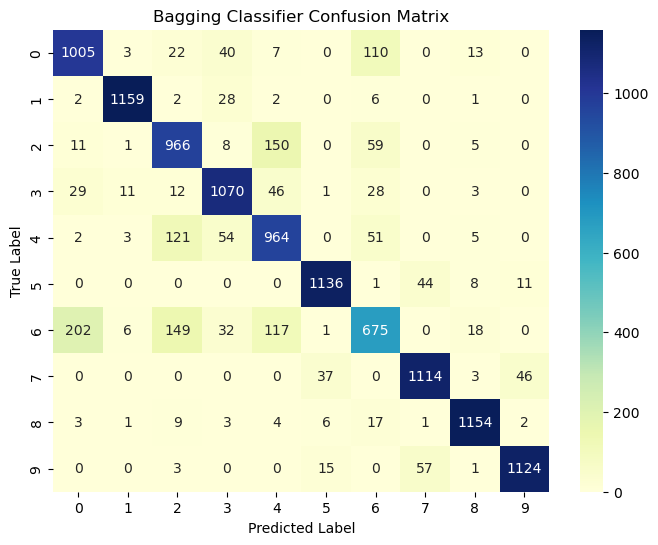

In [5]:
import time
tic = time.time()


# Initialize a base estimator: Decision Tree
base_dt = DecisionTreeClassifier(random_state=RANDOM_STATE)

# Initialize the Bagging Classifier using the base estimator and fixed hyperparameters
bagging = BaggingClassifier(
    n_estimators=20,         # Fewer trees for quicker training
    max_samples=0.33,         # Use samples for each base estimator
    max_features=0.33,        # Use features for each base estimator
    random_state=RANDOM_STATE
)

# Train the Bagging Classifier
bagging.fit(X_train, y_train)
toc = time.time()
time4 = toc - tic
print(toc - tic , "sec")
# Evaluate the model on the validation set
y_pred_bagging = bagging.predict(X_val)
accuracy_bagging = accuracy_score(y_val, y_pred_bagging)
print("Bagging Classifier Accuracy on Validation set: {:.4f}".format(accuracy_bagging))
print("\nClassification Report for Bagging Classifier:")
print(classification_report(y_val, y_pred_bagging))

# Plot confusion matrix for the Bagging Classifier
cm_bagging = confusion_matrix(y_val, y_pred_bagging)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_bagging, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Bagging Classifier Confusion Matrix")
plt.show()

# ---- Model 5: XGBoost Classifier using RandomizedSearchCV ----

י • תיאור: אלגוריתם מבוסס עצים משופר ($Gradient Boosting$). י  
י • יתרונות: י  
י • דיוק גבוה. י   
י • מתאים במיוחד לנתונים מורכבים. י  
י • חסרונות: י  
י • זמן אימון ארוך. י  
י • דורש כיוונון פרמטרים זהיר. י  
י • דיוק: $88.54%$. י  

42.17492079734802 sec
XGBoost Accuracy on Validation set: 0.8854

Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84      1200
           1       0.99      0.98      0.99      1200
           2       0.80      0.82      0.81      1200
           3       0.89      0.90      0.90      1200
           4       0.78      0.83      0.81      1200
           5       0.98      0.96      0.97      1200
           6       0.71      0.63      0.67      1200
           7       0.93      0.96      0.95      1200
           8       0.97      0.97      0.97      1200
           9       0.96      0.95      0.95      1200

    accuracy                           0.89     12000
   macro avg       0.88      0.89      0.88     12000
weighted avg       0.88      0.89      0.88     12000



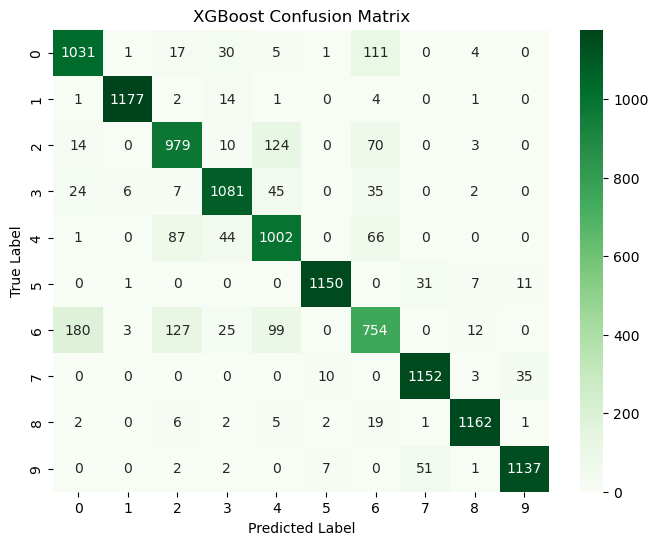

In [6]:
import time
tic = time.time()


# Initialize and train XGBClassifier with fixed hyperparameters
model = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    eval_metric='mlogloss',
    random_state=RANDOM_STATE
)
model.fit(X_train, y_train)

# Evaluate the model on the validation set
y_pred = model.predict(X_val)
accuracy_xgb = accuracy_score(y_val, y_pred)
toc = time.time()
print(toc - tic , "sec")
time5 = toc - tic
print("XGBoost Accuracy on Validation set: {:.4f}".format(accuracy_xgb))
print("\nClassification Report for XGBoost:")
print(classification_report(y_val, y_pred))

# Plot confusion matrix for XGBoost
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("XGBoost Confusion Matrix")
plt.show()

In [13]:
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import time 

tic = time.time()
# Load your data
df = pd.read_csv("train.csv")
X, y = df.drop('label', axis=1), df['label']

# Split data into training (80%) and validation (20%)
X_train_full, X_val, y_train_full, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Parameters for XGBoost
params = {
    'objective': 'multi:softmax',
    'num_class': 10,
    'max_depth': 5,
    'learning_rate': 0.1,
    'eval_metric': 'mlogloss',
}
np.random.seed(None)  # כל איטרציה תקבל seed אחר

num_rounds = 100  # Trees per iteration
chunk_size = 10000  # Size of each chunk
iterations = 10    # Number of iterations (repeats)

model = None  # Initialize the model as None

# Training loop
for i in range(iterations):
    print(f"Iteration {i+1}/{iterations}")
    
    # Select 1000 random samples WITH replacement
    idx_chunk = np.random.choice(len(X_train_full), chunk_size, replace=True)
    X_chunk, y_chunk = X_train_full.iloc[idx_chunk], y_train_full.iloc[idx_chunk]
    
    # Create DMatrix for XGBoost
    dtrain_chunk = xgb.DMatrix(X_chunk, label=y_chunk)
    
    # Train (warm-start if model exists)
    if model is None:
        model = xgb.train(params, dtrain_chunk, num_rounds)
    else:
        model = xgb.train(params, dtrain_chunk, num_rounds, xgb_model=model)
    accuracy = accuracy_score(y_val, y_pred)
    print(f"\n Validation Accuracy: {accuracy:.4f}")



# Final evaluation on validation set
dval = xgb.DMatrix(X_val)
y_pred = model.predict(dval)
print(f"\nFinal Validation Accuracy after {iterations} iterations: {accuracy:.4f}")

print(time.time() - tic, "sec")

Iteration 1/10

 Validation Accuracy after 10 iterations: 0.8253
Iteration 2/10

 Validation Accuracy after 10 iterations: 0.8253
Iteration 3/10

 Validation Accuracy after 10 iterations: 0.8253
Iteration 4/10


KeyboardInterrupt: 

# ---- Model 6: K-Nearest Neighbors Classifier using PCA-transformed data ----


י • תיאור: שימוש באלגוריתם אשכולות ($unsupervised$) עם קביעת התוויות לפי רוב באשכול. י  
י • יתרונות: י  
י • פשוט, ללא צורך בתוויות בעת יצירת אשכולות. י  
י • חסרונות: י  
י • הדיוק מוגבל בגלל שהוא לא $supervised$ במקור. י  
י • בחירה במספר האשכולות יכולה להיות שרירותית. י  
י • דיוק: $82.17%$. י  


Best KNN parameters: {'n_neighbors': 7, 'weights': 'distance'}
13.468140125274658 sec
KNN (with PCA) Accuracy on Validation set: 0.8645

Classification Report for KNN:
              precision    recall  f1-score   support

           0       0.80      0.85      0.82      1200
           1       1.00      0.97      0.98      1200
           2       0.77      0.79      0.78      1200
           3       0.90      0.88      0.89      1200
           4       0.76      0.80      0.78      1200
           5       0.98      0.88      0.93      1200
           6       0.67      0.63      0.65      1200
           7       0.90      0.95      0.92      1200
           8       0.97      0.96      0.97      1200
           9       0.91      0.95      0.93      1200

    accuracy                           0.86     12000
   macro avg       0.87      0.86      0.86     12000
weighted avg       0.87      0.86      0.86     12000



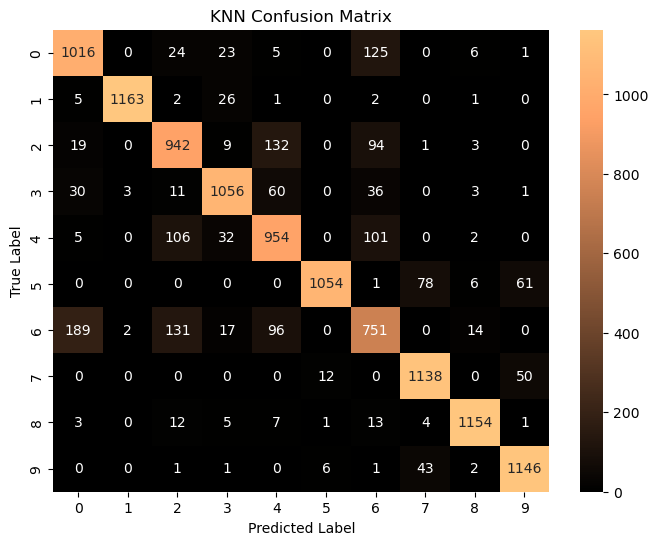

In [7]:
import time
tic = time.time()


from sklearn.neighbors import KNeighborsClassifier

# We'll use the PCA-transformed data (X_train_pca and X_val_pca) from Model 1
knn = KNeighborsClassifier()

# Define hyperparameter grid for KNN
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance']
}

# Use GridSearchCV with 3-fold CV
grid_knn = GridSearchCV(knn, param_grid_knn, cv=3, scoring='accuracy', n_jobs=-1)
grid_knn.fit(X_train_pca, y_train)

print("Best KNN parameters:", grid_knn.best_params_)
best_knn = grid_knn.best_estimator_

# Evaluate KNN model
y_pred_knn = best_knn.predict(X_val_pca)
accuracy_knn = accuracy_score(y_val, y_pred_knn)
toc = time.time()
time6 = toc - tic
print(toc - tic , "sec")
print("KNN (with PCA) Accuracy on Validation set: {:.4f}".format(accuracy_knn))
print("\nClassification Report for KNN:")
print(classification_report(y_val, y_pred_knn))

# Plot confusion matrix for KNN
cm_knn = confusion_matrix(y_val, y_pred_knn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='copper', 
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("KNN Confusion Matrix")
plt.show()

# ---- Model 7: K-Means Classifier (unsupervised clustering based classification) ----


י • תיאור: אלגוריתם אשכולות היררכי לקביעת שיוך לקטגוריות. י  
י • יתרונות: י    
י • מאפשר ניתוח מבנה היררכי של הנתונים. י  
י • חסרונות: י  
י • דיוק נמוך משמעותית במטלת סיווג זו. י  
י • אינו מתאים במיוחד לנתונים גדולים מאוד. י  
י • דיוק: נמוך (פחות מהמודלים האחרים). י  

9.272031784057617 sec
K-Means Classification Accuracy on Validation set: 0.8217

Classification Report for K-Means:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84      1200
           1       0.99      0.98      0.99      1200
           2       0.80      0.82      0.81      1200
           3       0.89      0.90      0.90      1200
           4       0.78      0.83      0.81      1200
           5       0.98      0.96      0.97      1200
           6       0.71      0.63      0.67      1200
           7       0.93      0.96      0.95      1200
           8       0.97      0.97      0.97      1200
           9       0.96      0.95      0.95      1200

    accuracy                           0.89     12000
   macro avg       0.88      0.89      0.88     12000
weighted avg       0.88      0.89      0.88     12000



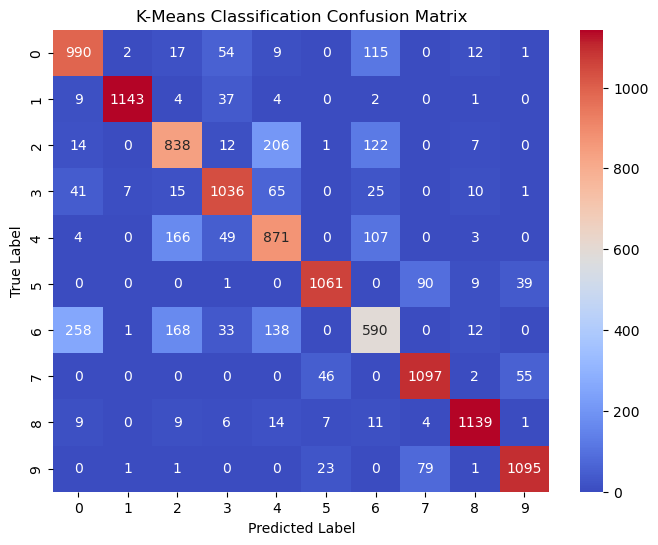

In [8]:
from sklearn.cluster import KMeans
from scipy.stats import mode
import time
tic = time.time()


n_clusters=2000

# We'll use the PCA-transformed data (X_train_pca and X_val_pca)
kmeans = KMeans(n_clusters=n_clusters, random_state=RANDOM_STATE)
clusters_train = kmeans.fit_predict(X_train_pca)

# Create mapping from cluster index to label via majority vote
cluster_label_mapping = {}
for i in range(n_clusters):
    # Get the true labels for all samples in cluster i
    labels_in_cluster = y_train[clusters_train == i]
    if len(labels_in_cluster) > 0:
        cluster_label_mapping[i] = np.bincount(labels_in_cluster).argmax()
    else:
        cluster_label_mapping[i] = -1  # fallback; not expected to occur

# Predict clusters for validation data and map to labels
clusters_val = kmeans.predict(X_val_pca)
y_pred_kmeans = np.array([cluster_label_mapping[cluster] for cluster in clusters_val])

toc = time.time()
print(toc - tic , "sec")
time7 = toc - tic
accuracy_kmeans = accuracy_score(y_val, y_pred_kmeans)
print("K-Means Classification Accuracy on Validation set: {:.4f}".format(accuracy_kmeans))
print("\nClassification Report for K-Means:")
print(classification_report(y_val, y_pred, zero_division=0))

# Plot confusion matrix for K-Means
cm_kmeans = confusion_matrix(y_val, y_pred_kmeans)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_kmeans, annot=True, fmt='d', cmap='coolwarm', 
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("K-Means Classification Confusion Matrix")
plt.show()


In [9]:

# ------------------------------
# 4. Summary of Model Performances
# ------------------------------

print("Summary of Model Performances:")
print("Logistic Regression (with PCA): {:.4f} Accuracy".format(accuracy_lr))
print(time1, "SEC")
print("Random Forest: {:.4f} Accuracy".format(accuracy_rf))
print(time2, "SEC")
print("Naive Bayes: {:.4f} Accuracy".format(accuracy_nb))
print(time3, "SEC")
print("Bagging Classifier: {:.4f} Accuracy".format(accuracy_bagging))
print(time4, "SEC")
print("XGBoost: {:.4f} Accuracy".format(accuracy_xgb))
print(time5, "SEC")
print("KNN (with PCA): {:.4f} Accuracy".format(accuracy_knn))
print(time6, "SEC")
print("K-Means: {:.4f} Accuracy".format(accuracy_kmeans))
print(time7, "SEC")


Summary of Model Performances:
Logistic Regression (with PCA): 0.8487 Accuracy
16.24952793121338 SEC
Random Forest: 0.8793 Accuracy
71.909010887146 SEC
Naive Bayes: 0.5855 Accuracy
0.3390059471130371 SEC
Bagging Classifier: 0.8639 Accuracy
27.921977043151855 SEC
XGBoost: 0.8854 Accuracy
42.17492079734802 SEC
KNN (with PCA): 0.8645 Accuracy
13.468140125274658 SEC
K-Means: 0.8217 Accuracy
9.272031784057617 SEC


# CNN approach


י • תיאור: רשת עצבית קונבולוציונית עמוקה המיועדת לנתוני תמונות. י  
י • יתרונות: י  
י • הדיוק הגבוה ביותר מכל המודלים. י  
י • מסוגלת לתפוס מורכבות גבוהה בנתונים. י  
י • חסרונות: י  
י • זמני אימון ארוכים מאוד. י  
י • צורך במשאבי חישוב משמעותיים. י  
י • דיוק: $90.53%$ (הכי גבוה). י  

In [83]:
# Import necessary libraries for the CNN approach
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Preprocess data for CNN: reshape from 784 features to 28x28x1 images
X_train_cnn = X_train.values.reshape(-1, 28, 28, 1)
X_val_cnn   = X_val.values.reshape(-1, 28, 28, 1)

# Convert labels to one-hot encoding
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_val_cat   = tf.keras.utils.to_categorical(y_val, num_classes=10)

# Create ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,       # Rotate images up to 10 degrees
    width_shift_range=0.1,   # Shift images horizontally by 10% of the width
    height_shift_range=0.1,  # Shift images vertically by 10% of the height
    zoom_range=0.1           # Zoom in/out by 10%
)
datagen.fit(X_train_cnn)

# Build a simple CNN model using an Input layer for specifying the input shape
cnn_model = Sequential([
    Input(shape=(28, 28, 1)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # Dropout to help reduce overfitting
    Dense(10, activation='softmax')
])

# Compile the model with Adam optimizer and categorical crossentropy loss
cnn_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Setup callbacks for early stopping and model checkpointing
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint("best_cnn_model.keras", monitor="val_accuracy", save_best_only=True)
]

# Train the model using the augmented data
history = cnn_model.fit(
    datagen.flow(X_train_cnn, y_train_cat, batch_size=64),
    epochs=30,
    validation_data=(X_val_cnn, y_val_cat),
    callbacks=callbacks
)

# Evaluate the CNN model on the validation set
loss, accuracy = cnn_model.evaluate(X_val_cnn, y_val_cat)
print("CNN Model Validation Accuracy: {:.4f}".format(accuracy))

Epoch 1/30


/Users/djourno/Library/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.6078 - loss: 1.0723 - val_accuracy: 0.7943 - val_loss: 0.5146
Epoch 2/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7558 - loss: 0.6453 - val_accuracy: 0.8265 - val_loss: 0.4537
Epoch 3/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.7837 - loss: 0.5717 - val_accuracy: 0.8516 - val_loss: 0.3932
Epoch 4/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8060 - loss: 0.5236 - val_accuracy: 0.8677 - val_loss: 0.3634
Epoch 5/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8190 - loss: 0.4917 - val_accuracy: 0.8690 - val_loss: 0.3453
Epoch 6/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8301 - loss: 0.4603 - val_accuracy: 0.8719 - val_loss: 0.3325
Epoch 7/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8390 - loss: 0.4397 - val_accuracy: 0.8849 - val_loss: 0.3136
Epoch 8/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8449 - loss: 0.4204 - val_accuracy: 0.8791 - val_